In [ ]:
# To do:
# special thank you to ... 
# create markdown sections (including fMRIPrep website, nilearn website etc.) and put references
# improve comments and add print statements to facilitate human understanding
# add error tests
# 
# load afni files
# load atlas(es) for parcellation (standard and/or data-driven)
#
# Nilearn for FC (normal corr, partial corr or tangent space embedding, the latter of which has been shown to be the best?) 
# Graphpype (from Neuropycon) to calculate graph theory metrics
# Analysis of graph metrics, FC and neuropsych scores etc. using PCA, CCA and then SVM, e.g. ?????????
# 
# hypotheses and contrasts
# significance testing and multiple comparisons correction (e.g. Permutation testing or Hierarchical Bayes??)
# 
# Also check the EverNote notes !!!!!

In [ ]:
# This script is to be used on pre-processed fMRI timeseries data 

In [ ]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Copy the script onto the external HDD and try it from there???? !!!!!!!!!!!

In [1]:
import glob
import os

import pandas as pd
import numpy as np
from numpy import mean
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns

from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests
import statannot
from statannot import add_stat_annotation

import xlrd
import itertools

from nipype.interfaces import afni
import nibabel as nib
from nilearn import image
from nilearn import plotting
from nilearn import datasets
from nilearn import input_data
from nilearn.input_data import NiftiMapsMasker
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.plotting import plot_design_matrix

import graph_tool.all as gt

from sklearn.preprocessing import StandardScaler

In [86]:
# load an image from a single brain:
fmri_image_folder = "/Volumes/Seagate Dr/PhD/Chapter 2"
fmri_image_path = os.path.join(fmri_image_folder, "F001_A.nii")
fmri_image = nib.load(fmri_image_path)
print(fmri_image.shape)

(55, 65, 55, 182)



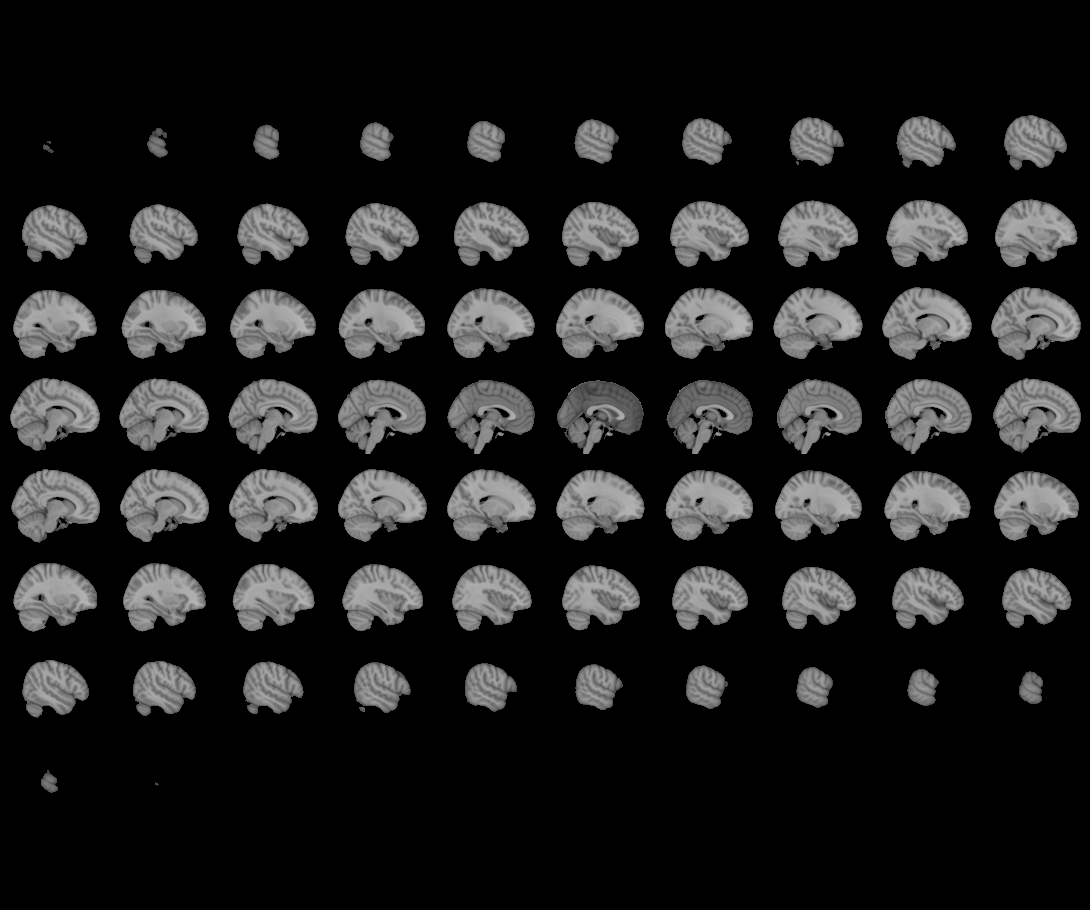
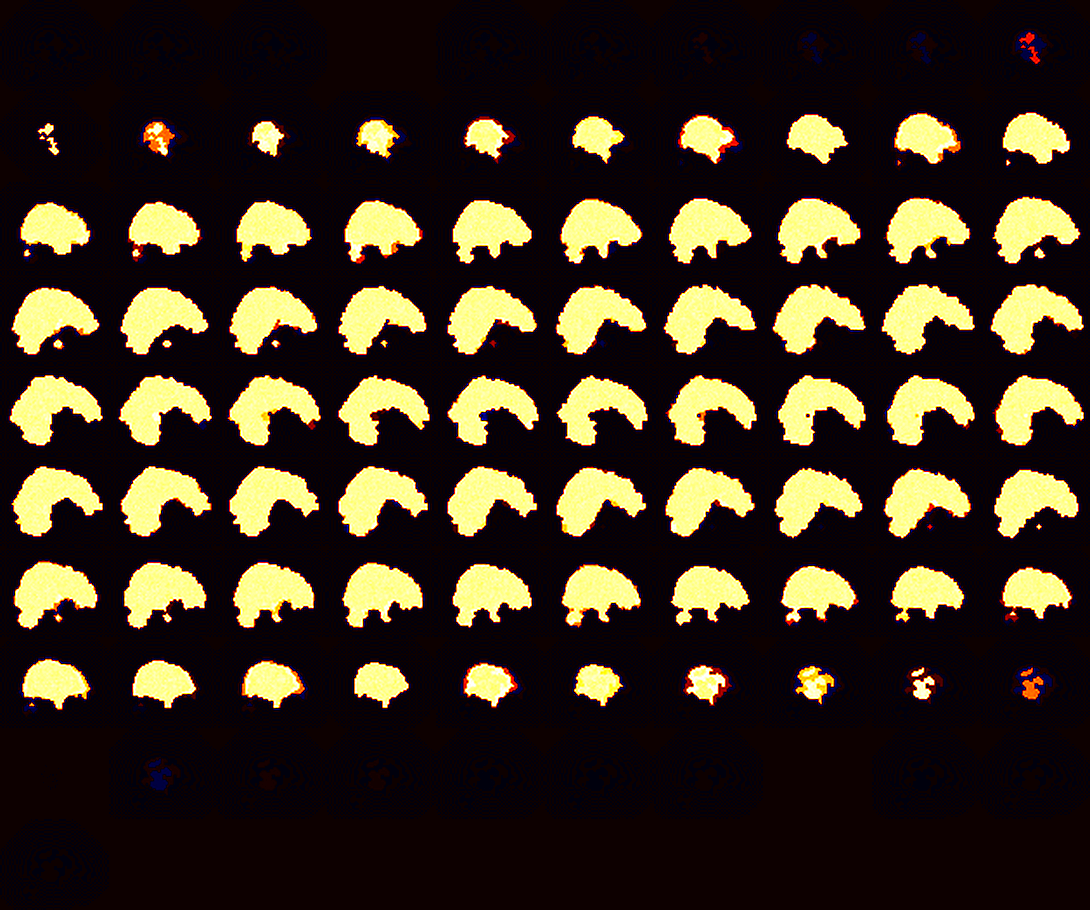

In [87]:
# to look at the mean fMRI brain image for a single participant
mean_image = image.mean_img(fmri_image)
plotting.view_img(mean_image, threshold=None)

In [97]:
# create a NiftiMasker object
brain_masker = input_data.NiftiMasker(detrend=True, standardize=True, t_r=2.5, memory='nilearn_cache', memory_level=1, verbose=0)
brain_time_series = brain_masker.fit_transform(fmri_image)

In [98]:
print("Brain time series shape: (%s, %s)" % brain_time_series.shape)

Brain time series shape: (182, 34921)


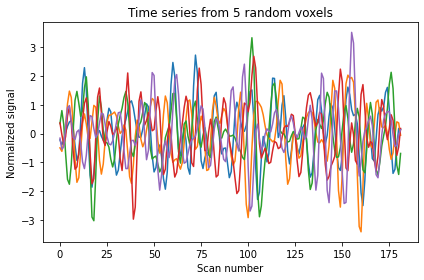

In [99]:
plt.plot(brain_time_series[:, [10, 45, 100, 5000, 10000]])
plt.title('Time series from 5 random voxels')
plt.xlabel('Scan number')
plt.ylabel('Normalized signal')
plt.tight_layout()

In [100]:
brain_time_series.mean()

-6.530267e-10

In [ ]:
# SHOULD I CONVOLVE THE SIGNAL WITH HRF? / Use deconvolution to calculate HRF variability??
# https://pubmed.ncbi.nlm.nih.gov/29656446/
# https://pubmed.ncbi.nlm.nih.gov/30013915/

# check the paper by Holiga et al.,2019 !

# https://nilearn.github.io/auto_examples/04_glm_first_level/plot_hrf.html#sphx-glr-auto-examples-04-glm-first-level-plot-hrf-py


In [101]:
# https://nilearn.github.io/auto_examples/03_connectivity/plot_seed_to_voxel_correlation.html

voxel_to_voxel_correlations = (np.matmul(brain_time_series.T, brain_time_series) /
                              brain_time_series.shape[0]
                              )

In [102]:
print("Voxel-to-voxel correlation shape: (%s, %s)" %
      voxel_to_voxel_correlations.shape)
print("Voxel-to-voxel correlation: min = %.3f; max = %.3f" % (
    voxel_to_voxel_correlations.min(), voxel_to_voxel_correlations.max()))

Voxel-to-voxel correlation shape: (34921, 34921)
Voxel-to-voxel correlation: min = -0.954; max = 1.000


In [10]:
type(voxel_to_voxel_correlations)

numpy.ndarray

In [11]:
voxel_to_voxel_correlations

array([[ 0.9999995 , -0.31734407,  0.29928797, ...,  0.18470444,
         0.15932947,  0.06040451],
       [-0.31734407,  0.9999998 ,  0.34549356, ...,  0.01804115,
        -0.00104034,  0.08121189],
       [ 0.29928797,  0.34549356,  1.0000001 , ...,  0.56715083,
         0.3224489 ,  0.15820917],
       ...,
       [ 0.18470444,  0.01804115,  0.56715083, ...,  1.0000001 ,
         0.8168269 ,  0.51636505],
       [ 0.15932947, -0.00104034,  0.3224489 , ...,  0.8168269 ,
         0.9999996 ,  0.8563969 ],
       [ 0.06040451,  0.08121189,  0.15820917, ...,  0.51636505,
         0.8563969 ,  1.0000001 ]], dtype=float32)

In [11]:
# threshold at r > 0.25
correlation_matrix = voxel_to_voxel_correlations
correlation_matrix[correlation_matrix < 0.25] = 0
#correlation_matrix

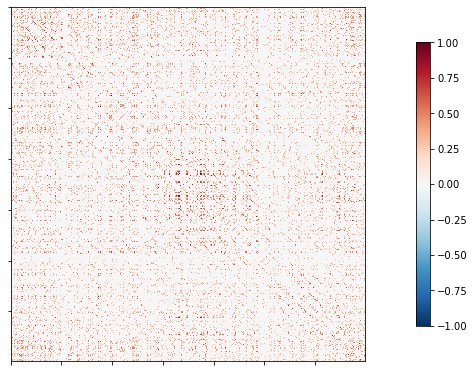

In [23]:
# # plot a connectivity matrix
# set this to a matrix of your choice
#correlation_matrix = voxel_to_voxel_correlations
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, 
                     # omit the first label as that is the "background" ROI, which wasn't actually used !
                     #labels=harv_oxf_atlas.labels[1:],
                     vmax=1, vmin=-1, colorbar=True)

In [14]:
unique_elements, counts_elements = np.unique(correlation_matrix, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[0.00000000e+00 2.50000000e-01 2.50000030e-01 ... 1.00000119e+00
  1.00000131e+00 1.00000155e+00]
 [1.06742746e+09 2.20000000e+01 3.60000000e+01 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]]


In [26]:
# check a small subset of the data to verify graph generation is accurate

In [13]:
adj = correlation_matrix[:5,:5]
# np.fill_diagonal(adj, 0) # fill diagonal with zeroes, if it hasn't been done already

In [14]:
adj

array([[0.        , 0.        , 0.29928797, 0.63431513, 0.42976892],
       [0.        , 0.        , 0.34549356, 0.        , 0.        ],
       [0.29928797, 0.34549356, 0.        , 0.7592736 , 0.38660288],
       [0.63431513, 0.        , 0.7592736 , 0.        , 0.80052704],
       [0.42976892, 0.        , 0.38660288, 0.80052704, 0.        ]],
      dtype=float32)

In [12]:
# https://carlonicolini.github.io/sections/science/2018/09/12/weighted-graph-from-adjacency-matrix-in-graph-tool.html

# to create an undirected, weighted graph

def to_graph_tool(adj):
    g = gt.Graph(directed=False)
    edge_weights = g.new_edge_property('double')
    g.edge_properties['weight'] = edge_weights
    nnz = np.nonzero(np.triu(adj,1))
    nedges = len(nnz[0])
    g.add_edge_list(np.hstack([np.transpose(nnz),np.reshape(adj[nnz],(nedges,1))]),eprops=[edge_weights])
    return g

In [15]:
gm = to_graph_tool(adj)

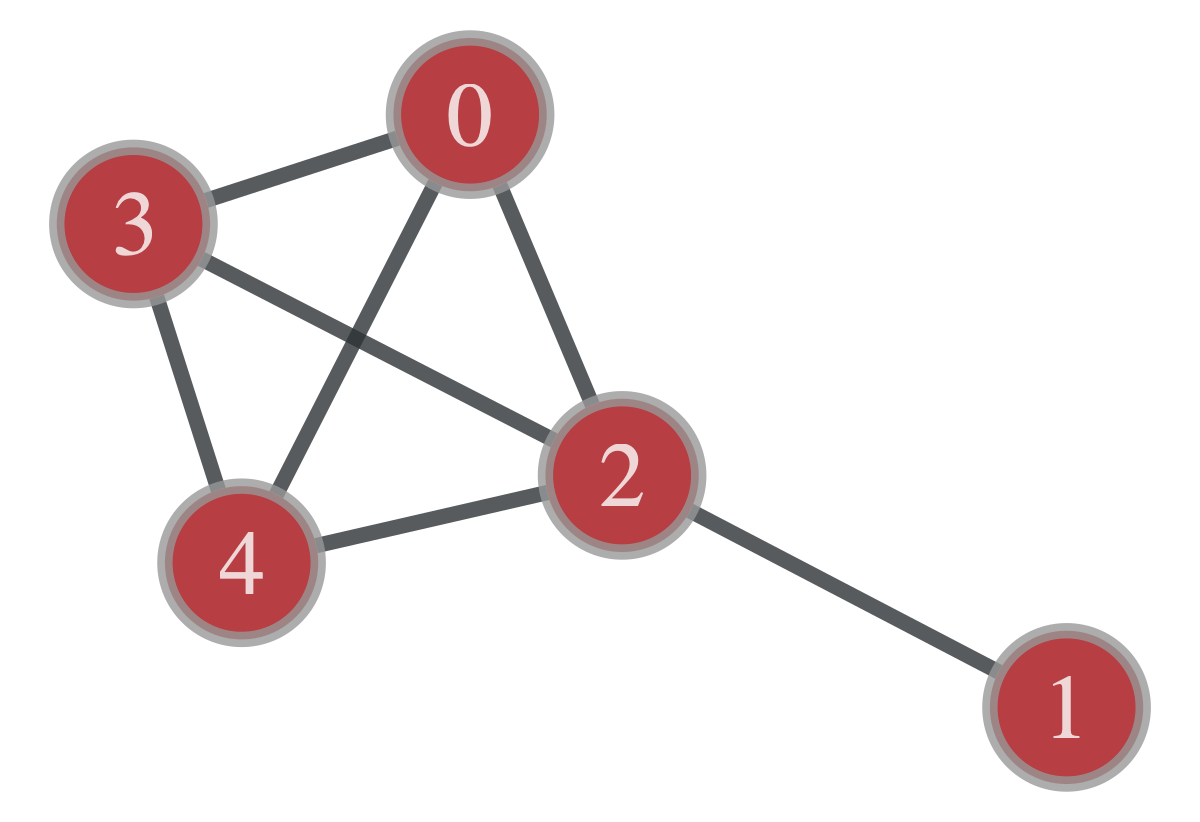

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1187fdd90, at 0x11884a610>

In [16]:
# draw the graph
# check https://www.slideshare.net/moskytw/graphtool-in-practice , slide 46 to adjust weighted edges visualisation
gt.graph_draw(gm, vertex_text=gm.vertex_index#, eprops=[edge_weights]
                          )

In [46]:
# get the degrees
gm.get_total_degrees([4])

array([3], dtype=uint64)

In [ ]:
# use whole dataset for current participant

In [13]:
np.fill_diagonal(correlation_matrix, 0)
g = to_graph_tool(correlation_matrix)

In [14]:
# repeat dc steps..

In [62]:
dc = g.get_total_degrees([i for i in range(brain_time_series.shape[1])])
dc

array([2712, 5380, 9894, ..., 5858, 3536, 2959], dtype=uint64)

In [16]:
print(np.min(dc))
print(np.max(dc))

426
10455


In [17]:
# z-score

In [18]:
# normalise dc values
scaler = StandardScaler()
dc = dc.reshape(-1, 1)
dc_scaled = scaler.fit_transform(dc)

In [19]:
dc_scaled

array([[-0.93107314],
       [ 0.5826283 ],
       [ 3.14366588],
       ...,
       [ 0.85382368],
       [-0.46357314],
       [-0.79093661]])

In [20]:
print(np.min(dc_scaled))
print(np.max(dc_scaled))

-2.2280452029068214
3.4619516766959517


In [21]:
dc_scaled_panda = pd.DataFrame(dc_scaled)
dc_scaled_panda.describe()

,0
count,34921.000000
mean,0.000000
std,1.000014
min,-2.228045
25%,-0.747818
50%,-0.092523
75%,0.623478
max,3.461952


In [31]:
# ???????????????????????????????????????????????????????????

# calculate the mean and the SD of the global connectivity and use them to z-score (as in Holiga et al., 2019):

#A previously recommended correlation threshold for DC of r > 0.25 was used for DC
#computation (26). The resulting DC maps were z-scored to the global connectivity (subtracting the mean
#and dividing by the standard deviation) for each subject to minimize the impact of global connectivity
#differences induced by potential confounds (i.e. motion, physiological noise or sequence differences).

mean_glob_conn = np.mean(correlation_matrix)
SD_glob_conn = np.std(correlation_matrix)
dc_z = (dc_scaled - mean_glob_conn) / SD_glob_conn
print(np.min(dc_z))
print(np.max(dc_z))

-17.76056434701654
26.677376520632013


In [34]:
dc_z_panda = pd.DataFrame(dc_z)
dc_z_panda.describe()

,0
count,34921.000000
mean,-0.359897
std,7.809948
min,-17.760564
25%,-6.200231
50%,-1.082490
75%,4.509362
max,26.677377


In [ ]:
# plot significant ones onto a brain atlas, check: 
# https://nilearn.github.io/auto_examples/03_connectivity/plot_seed_to_voxel_correlation.html

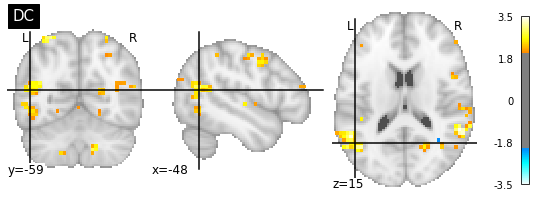

In [22]:
# static atlas
dc_img = brain_masker.inverse_transform(
    dc_scaled.T)
display = plotting.plot_stat_map(dc_img,
                                 threshold=2, vmax=3.5,
                                 #cut_coords=pcc_coords[0],
                                 title="DC"
                                 )


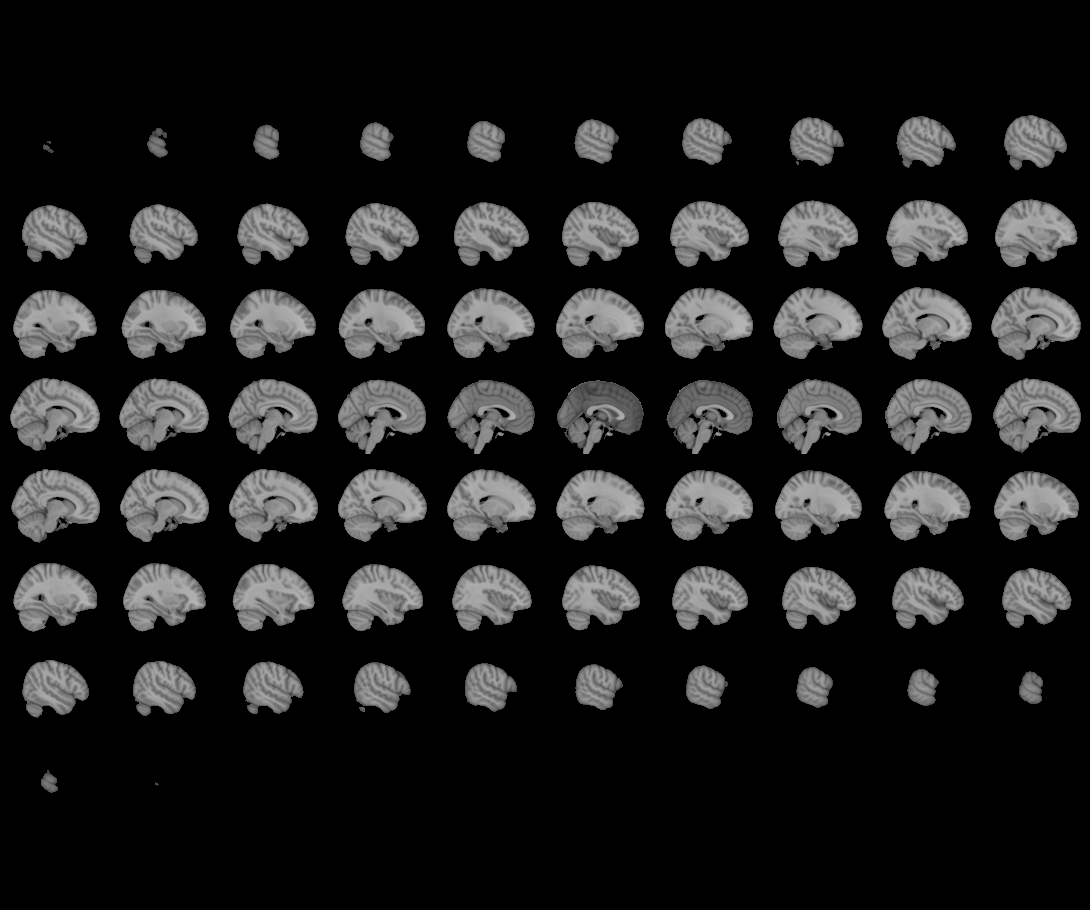
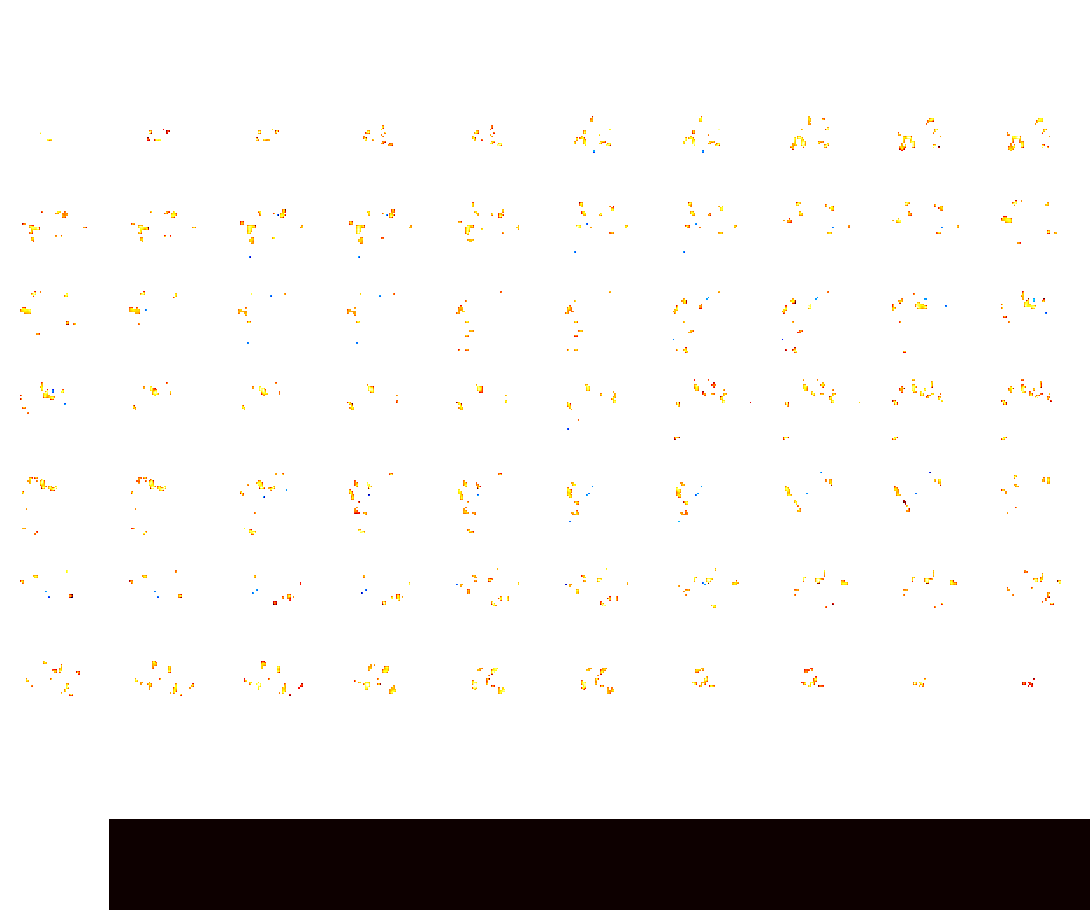

In [23]:
# interactive atlas
plotting.view_img(dc_img,
                     threshold=2, vmax=3.5,
                     #cut_coords=pcc_coords[0],
                     title="DC"
                     )

In [ ]:
# continue with all participants [choose which ones!!!]

In [ ]:
# check if IQ and Age are significantly different between ASD and TD groups

In [ ]:
# load the excel file (encrypted!!) and the 3rd sheet
# split the dataframe into ASD and TD
# do a t-test on both factors

In [ ]:
# ADD movement !!!!!!!!!!!!!!!!!!!!!

In [4]:
df_all = pd.read_excel(r'/Users/mishodimitrov/Downloads/PhD/Analysis/ARB DC/ARB_cov.xlsx', sheet_name='Pr 2', engine='openpyxl')
df_all

,ID,Age,Full-scale IQ,Unnamed: 3
0,M001,33,124.0,NaN
1,M002,26,125.0,NaN
2,M004,52,121.0,NaN
3,M005,23,119.0,NaN
4,M006,18,95.0,NaN
...,...,...,...,...
60,F104,46,126.0,NaN
61,F106,34,NaN,NaN
62,F107,26,99.0,NaN
63,F109,34,105.0,NaN


In [6]:
# df_all = df_all[]

In [ ]:
df_asd = 
df_td = 

In [46]:
# load the whole dataset
rootDir = "/Volumes/Seagate Dr/PhD/Chapter 2"
full_fmri_list = [os.path.relpath(os.path.join(dirpath, file), rootDir) for (dirpath, dirnames, filenames) in os.walk(rootDir) for file in filenames]
full_fmri_list

['F001_A.nii',
 'F001_B.nii',
 'F002_B.nii',
 'F002_C.nii',
 'F003_A.nii',
 'F003_B.nii',
 'F003_C.nii',
 'F004_A.nii',
 'F004_B.nii',
 'F004_C.nii',
 'F005_A.nii',
 'F005_C.nii',
 'F006_A.nii',
 'F006_B.nii',
 'F006_C.nii',
 'F007_B.nii',
 'F007_C.nii',
 'F008_A.nii',
 'F008_B.nii',
 'F008_C.nii',
 'F009_A.nii',
 'F009_B.nii',
 'F009_C.nii',
 'F010_A.nii',
 'F010_B.nii',
 'F011_A.nii',
 'F011_B.nii',
 'F011_C.nii',
 'F012_A.nii',
 'F012_B.nii',
 'F012_C.nii',
 'F013_A.nii',
 'F013_B.nii',
 'F014_A.nii',
 'F014_B.nii',
 'F014_C.nii',
 'F016_A.nii',
 'F016_C.nii',
 'F103_A.nii',
 'F103_B.nii',
 'F103_C.nii',
 'F104_A.nii',
 'F106_A.nii',
 'F106_B.nii',
 'F107_A.nii',
 'F107_B.nii',
 'F107_C.nii',
 'F109_A.nii',
 'F109_C.nii',
 'F110_A.nii',
 'F110_B.nii',
 'F110_C.nii',
 'M001_A.nii',
 'M001_B.nii',
 'M001_C.nii',
 'M002_A.nii',
 'M002_B.nii',
 'M002_C.nii',
 'M003_A.nii',
 'M004_A.nii',
 'M004_B.nii',
 'M004_C.nii',
 'M005_A.nii',
 'M005_B.nii',
 'M005_C.nii',
 'M006_A.nii',
 'M006_B.n

In [63]:
# path to the fMRI folder
fmri_image_folder = "/Volumes/Seagate Dr/PhD/Chapter 2"

# empty dictionary to be filled with participant IDs and corresponding DC values
dc_vals = {}

# to create an undirected, weighted graph
def to_graph_tool(adj):
    g = gt.Graph(directed=False)
    edge_weights = g.new_edge_property('double')
    g.edge_properties['weight'] = edge_weights
    nnz = np.nonzero(np.triu(adj,1))
    nedges = len(nnz[0])
    g.add_edge_list(np.hstack([np.transpose(nnz),np.reshape(adj[nnz],(nedges,1))]),eprops=[edge_weights])
    return g


# to calculate functional connectivity and degree centrality
def calc_dc(fmri_list):
    for i in range(len(fmri_list)):
        # load an image from a single brain:
        fmri_image_path = os.path.join(fmri_image_folder, fmri_list[i])
        fmri_image = nib.load(fmri_image_path)
        print("Participant " + fmri_list[i])
        print("The image dimensions are: " + str(fmri_image.shape))
        
        # create a NiftiMasker object
        brain_masker = input_data.NiftiMasker(detrend=True, standardize=True, t_r=2.5, memory='nilearn_cache', memory_level=1, verbose=0)
        brain_time_series = brain_masker.fit_transform(fmri_image)
        
        # calculate the correlations between each pair of voxels
        voxel_to_voxel_correlations = (np.matmul(brain_time_series.T, brain_time_series) /
                                      brain_time_series.shape[0])
        print("Correlations calculated.")
        
        # threshold at r > 0.25
        correlation_matrix = voxel_to_voxel_correlations
        correlation_matrix[correlation_matrix < 0.25] = 0
        print("Correlation matrix thresholded.")
        
        # fill diagonal with zeroes
        np.fill_diagonal(correlation_matrix, 0)
        print("Correlation matrix diagonal set to 0.")
        
        # calculate the degree centrality (DC)
        g = to_graph_tool(correlation_matrix)
        dc = g.get_total_degrees([i for i in range(brain_time_series.shape[1])])
        print("DC values calcualted.")
        
        # z-score the DC values
        scaler = StandardScaler()
        dc = dc.reshape(-1, 1)
        dc_scaled = scaler.fit_transform(dc)
        print("DC values z-scored.")

        # add the dc values and their matching participant ID to the dc_vals dictionary
        dc_vals[fmri_list[i]] = dc_scaled
        print("Dictionary updated.")

In [64]:
small_fmri_list = full_fmri_list[0:2]
small_fmri_list

['F001_A.nii', 'F001_B.nii']

In [65]:
calc_dc(small_fmri_list)

Participant F001_A.nii
The image dimensions are: (55, 65, 55, 182)
Correlations calculated.
Correlation matrix thresholded.
Correlation matrix diagonal set to 0.
DC values calcualted.
DC values z-scored.
Dictionary updated.
Participant F001_B.nii
The image dimensions are: (55, 65, 55, 182)
Correlations calculated.
Correlation matrix thresholded.
Correlation matrix diagonal set to 0.
DC values calcualted.
DC values z-scored.
Dictionary updated.


In [66]:
dc_vals

{'F001_A.nii': array([[-0.93107314],
        [ 0.5826283 ],
        [ 3.14366588],
        ...,
        [ 0.85382368],
        [-0.46357314],
        [-0.79093661]]),
 'F001_B.nii': array([[-1.36578966],
        [-0.93354809],
        [-1.04375796],
        ...,
        [-1.34703053],
        [-1.16725556],
        [-2.03564684]])}

In [ ]:
# A > B contrast - just a test
# https://nilearn.github.io/auto_examples/05_glm_second_level/plot_second_level_two_sample_test.html

In [67]:
from nilearn.datasets import fetch_localizer_contrasts
n_subjects = 16
sample_vertical = fetch_localizer_contrasts(
    ["vertical checkerboard"], n_subjects, get_tmaps=True)
sample_horizontal = fetch_localizer_contrasts(
    ["horizontal checkerboard"], n_subjects, get_tmaps=True)
second_level_input = sample_vertical['cmaps'] + sample_horizontal['cmaps']


Dataset created in /Users/mishodimitrov/nilearn_data/brainomics_localizer



 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)
/opt/anaconda3/envs/Project_2_ARB/lib/python3.9/site-packages/numpy/lib/npyio.py:2349: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


In [70]:
second_level_input

['/Users/mishodimitrov/nilearn_data/brainomics_localizer/brainomics_data/S01/cmaps_VerticalCheckerboard.nii.gz',
 '/Users/mishodimitrov/nilearn_data/brainomics_localizer/brainomics_data/S02/cmaps_VerticalCheckerboard.nii.gz',
 '/Users/mishodimitrov/nilearn_data/brainomics_localizer/brainomics_data/S03/cmaps_VerticalCheckerboard.nii.gz',
 '/Users/mishodimitrov/nilearn_data/brainomics_localizer/brainomics_data/S04/cmaps_VerticalCheckerboard.nii.gz',
 '/Users/mishodimitrov/nilearn_data/brainomics_localizer/brainomics_data/S05/cmaps_VerticalCheckerboard.nii.gz',
 '/Users/mishodimitrov/nilearn_data/brainomics_localizer/brainomics_data/S06/cmaps_VerticalCheckerboard.nii.gz',
 '/Users/mishodimitrov/nilearn_data/brainomics_localizer/brainomics_data/S07/cmaps_VerticalCheckerboard.nii.gz',
 '/Users/mishodimitrov/nilearn_data/brainomics_localizer/brainomics_data/S08/cmaps_VerticalCheckerboard.nii.gz',
 '/Users/mishodimitrov/nilearn_data/brainomics_localizer/brainomics_data/S09/cmaps_VerticalCheck

In [71]:
second_level_input = dc_vals['F001_A.nii'] + dc_vals['F001_B.nii']

ValueError: operands could not be broadcast together with shapes (34921,1) (35288,1) 

In [ ]:
#We define the input maps and the design matrix for the second level model and fit it.
second_level_input = sample_vertical['cmaps'] + sample_horizontal['cmaps']

#Next, we model the effect of conditions (sample 1 vs sample 2).

condition_effect = np.hstack(([1] * n_subjects, [- 1] * n_subjects))

#Subsequently, we can model the subject effect: each subject is observed in sample 1 and sample 2.

subject_effect = np.vstack((np.eye(n_subjects), np.eye(n_subjects)))
subjects = ['S%02d' % i for i in range(1, n_subjects + 1)]

#We then assemble those in a design matrix and

design_matrix = pd.DataFrame(
    np.hstack((condition_effect[:, np.newaxis], subject_effect)),
    columns=['vertical vs horizontal'] + subjects)

#plot the design_matrix.
plot_design_matrix(design_matrix)

In [ ]:
# Generate summary statistics for both groups (ASD, TD) and all 3 drug conditions??????

In [ ]:
# plot DC results using the brain atlas coordinates and anatomical labels.. use nilearn plotting????????? (https://nilearn.github.io/auto_examples/03_connectivity/plot_seed_to_voxel_correlation.html)

In [ ]:
# Get all the non-imaging data - clean it up, pre-process it, scale it etc.

In [ ]:
# PCA (and CCA????) for dimensionality reduction 

In [ ]:
# Set-up the different contrasts

In [ ]:
# Assess the statistical significance